# Clusterização do Global Terrorism Database (GTD)

Este notebook implementa um fluxo completo de preparação, modelagem, avaliação e análise crítica para clusterização (K-Means e DBSCAN) no dataset `globalterrorismdb_0718dist.csv`.

Objetivos:
- Preparar e padronizar atributos relevantes para agrupamento.
- Determinar `k` ótimo para K-Means usando Silhouette e treinar o modelo.
- Aplicar DBSCAN com estimativa de `eps` via gráfico de k-vizinhos e escolher `min_samples`.
- Avaliar e comparar modelos com Silhouette, Davies-Bouldin e Calinski-Harabasz.
- Responder criticamente sobre a adequação da Silhouette para definir parâmetros do DBSCAN.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import issparse
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

## Preparação e Pré-processamento

- Carregamento do arquivo.
- Limpeza: tratamento de nulos e remoção de identificadores.
- Seleção de atributos principais: `iyear`, `imonth`, `iday`, `extended`, `region`.
- Conversão categórica: `region` via One-Hot Encoding (baixa cardinalidade).
- Padronização: `StandardScaler` aplicado nos atributos numéricos.

In [4]:
# %%
# Célula corrigida
df = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1', low_memory=False)

print(f'Linhas e colunas carregadas: {df.shape}')

# Remove eventid se existir
if 'eventid' in df.columns:
    df = df.drop(columns=['eventid'])

# Seleciona colunas
cols = ['iyear', 'imonth', 'iday', 'extended', 'region']
df = df[cols].copy()

# Tratamento de Nulos e Zeros
df['imonth'] = df['imonth'].replace(0, np.nan)
df['iday'] = df['iday'].replace(0, np.nan)

# Preenchimento de nulos com mediana para datas
for c in ['iyear', 'imonth', 'iday']:
    df[c] = df[c].fillna(df[c].median())

# Preenchimento de extended e region
df['extended'] = df['extended'].fillna(0)
mode_region = df['region'].mode(dropna=True)[0] if df['region'].notna().any() else 0
df['region'] = df['region'].fillna(mode_region)

# Definição das features
numeric_features = ['iyear', 'imonth', 'iday', 'extended']
categorical_features = ['region']

# Pipeline de transformação
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # force_int_category=False garante compatibilidade
        ('cat_region', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), 
    ],
    remainder='drop'
)

# Aplicar transformação
# Nota: sparse_output=False no OneHotEncoder já retorna array denso,
# não precisa de toarray(), mas mantivemos a lógica caso mude versões
X_processed = preprocessor.fit_transform(df)

# Garantia de formato array
if issparse(X_processed):
    X = X_processed.toarray()
else:
    X = X_processed

print(f'Dimensão após transformação: {X.shape}')

Linhas e colunas carregadas: (181691, 135)
Dimensão após transformação: (181691, 16)


## K-Means: escolha de k por Silhouette

- Avaliação de `k` em um intervalo [2, 10].
- Amostragem para acelerar o cálculo em conjuntos grandes.
- Gráfico das pontuações de Silhouette por `k` e seleção do melhor.

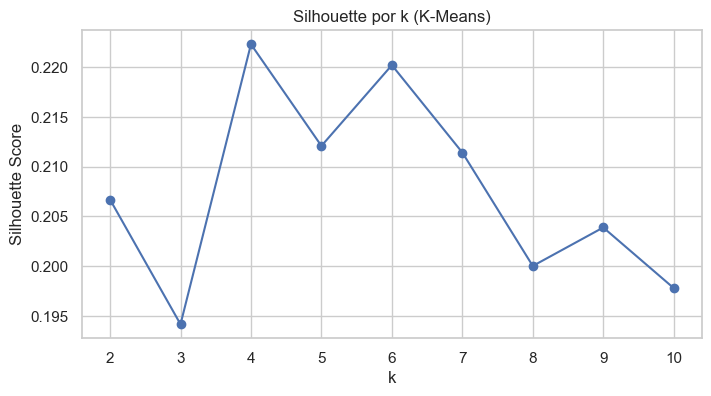

Melhor k: 4 (Silhouette=0.2223)
0    56332
1     8239
2    60922
3    56198
Name: count, dtype: int64


In [6]:
rng = np.random.RandomState(42)
max_samples = 20000
if X.shape[0] > max_samples:
    idx = rng.choice(X.shape[0], size=max_samples, replace=False)
    X_sample = X[idx]
else:
    X_sample = X
k_values = list(range(2, 11))
sil_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_sample)
    sil_scores.append(silhouette_score(X_sample, labels))
best_k = k_values[int(np.argmax(sil_scores))]
plt.figure(figsize=(8,4))
plt.plot(k_values, sil_scores, marker='o')
plt.xticks(k_values)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette por k (K-Means)')
plt.show()
print(f'Melhor k: {best_k} (Silhouette={max(sil_scores):.4f})')
km_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto').fit(X)
labels_km = km_final.labels_
print(pd.Series(labels_km).value_counts().sort_index())

### Gráfico de Silhueta (K-Means)

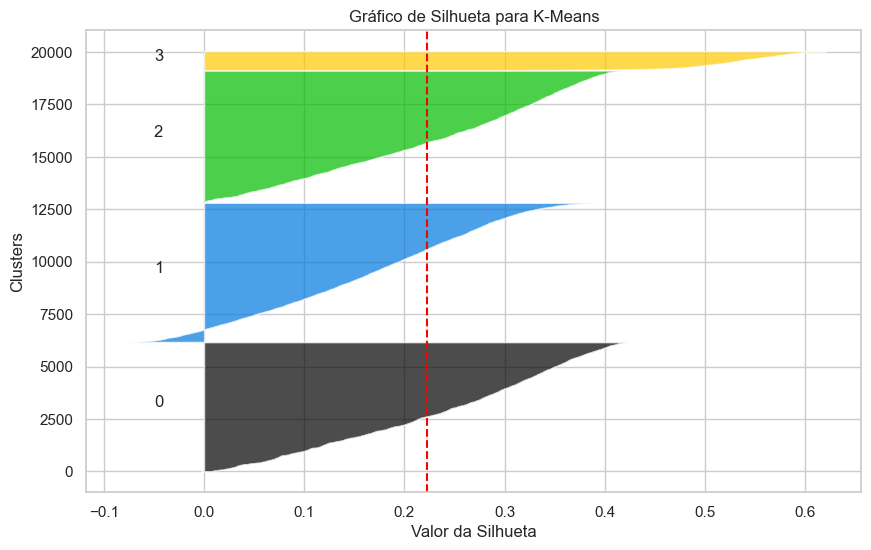

In [7]:
km_for_plot = KMeans(n_clusters=best_k, random_state=42, n_init='auto').fit(X_sample)
labels_plot = km_for_plot.labels_
sample_values = silhouette_samples(X_sample, labels_plot)
y_lower = 10
plt.figure(figsize=(10,6))
for i in range(best_k):
    ith = sample_values[labels_plot == i]
    ith.sort()
    size_i = ith.shape[0]
    y_upper = y_lower + size_i
    color = plt.cm.nipy_spectral(float(i) / best_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith, facecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10
plt.xlabel('Valor da Silhueta')
plt.ylabel('Clusters')
plt.title('Gráfico de Silhueta para K-Means')
plt.axvline(x=silhouette_score(X_sample, labels_plot), color='red', linestyle='--')
plt.show()

## DBSCAN: estimativa de parâmetros e treino

- `min_samples` definido proporcionalmente à dimensionalidade.
- `eps` estimado pelo gráfico de distâncias do k-vizinho e heurística do percentil.

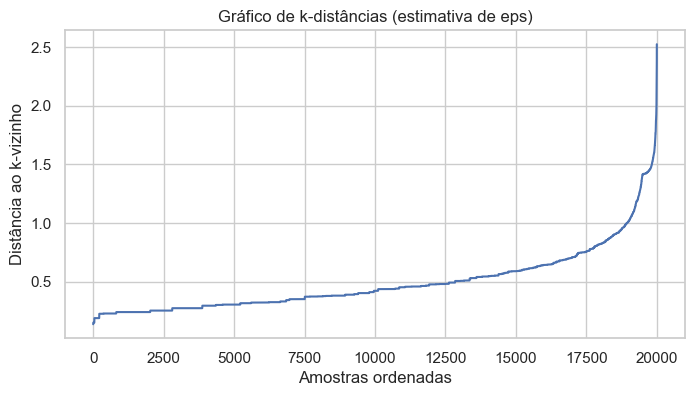

Parâmetros DBSCAN: eps≈1.0182, min_samples=32
-1       474
 0     10193
 1      3402
 2     11941
 3     16489
 4     18162
 5     15858
 6     48409
 7       792
 8     42458
 9       816
 10     4939
 11       85
 12     2052
 13      209
 14      531
 15     2515
 16     1671
 17      526
 18      169
Name: count, dtype: int64


In [8]:
feature_dim = X.shape[1]
min_samples = max(5, 2 * feature_dim)
nn = NearestNeighbors(n_neighbors=min_samples, n_jobs=-1)
nn.fit(X_sample)
distances, _ = nn.kneighbors(X_sample)
k_dist = distances[:, -1]
k_dist_sorted = np.sort(k_dist)
plt.figure(figsize=(8,4))
plt.plot(k_dist_sorted)
plt.xlabel('Amostras ordenadas')
plt.ylabel('Distância ao k-vizinho')
plt.title('Gráfico de k-distâncias (estimativa de eps)')
plt.show()
eps = float(np.quantile(k_dist, 0.95))
print(f'Parâmetros DBSCAN: eps≈{eps:.4f}, min_samples={min_samples}')
db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels_db = db.fit_predict(X)
print(pd.Series(labels_db).value_counts().sort_index())

## Avaliação e Comparação

- Silhueta para ambos (DBSCAN calculada apenas em pontos não-ruído e com ≥2 clusters).
- Métricas adicionais: Davies-Bouldin e Calinski-Harabasz.

In [9]:
sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
mask_db = labels_db != -1
sil_db = None
dbi_db = None
ch_db = None
if np.unique(labels_db[mask_db]).size >= 2:
    sil_db = silhouette_score(X[mask_db], labels_db[mask_db])
    dbi_db = davies_bouldin_score(X[mask_db], labels_db[mask_db])
    ch_db = calinski_harabasz_score(X[mask_db], labels_db[mask_db])
print('Resultados K-Means:')
print({'silhouette': sil_km, 'davies_bouldin': dbi_km, 'calinski_harabasz': ch_km})
print('Resultados DBSCAN (não-ruído):')
print({'silhouette': sil_db, 'davies_bouldin': dbi_db, 'calinski_harabasz': ch_db})
km_counts = pd.Series(labels_km).value_counts().sort_index()
db_counts = pd.Series(labels_db).value_counts().sort_index()
print('Distribuição K-Means:')
print(km_counts)
print('Distribuição DBSCAN (inclui -1 como ruído):')
print(db_counts)

Resultados K-Means:
{'silhouette': 0.2219998381283519, 'davies_bouldin': 1.3271929649460308, 'calinski_harabasz': 56759.536350796574}
Resultados DBSCAN (não-ruído):
{'silhouette': 0.15117502048967513, 'davies_bouldin': 2.0699587786331195, 'calinski_harabasz': 8767.981891142766}
Distribuição K-Means:
0    56332
1     8239
2    60922
3    56198
Name: count, dtype: int64
Distribuição DBSCAN (inclui -1 como ruído):
-1       474
 0     10193
 1      3402
 2     11941
 3     16489
 4     18162
 5     15858
 6     48409
 7       792
 8     42458
 9       816
 10     4939
 11       85
 12     2052
 13      209
 14      531
 15     2515
 16     1671
 17      526
 18      169
Name: count, dtype: int64


## Interpretação

- K-Means tende a formar grupos de forma aproximadamente convexa, equilibrados quando a variância é semelhante entre dimensões.
- DBSCAN identifica regiões densas e marca pontos esparsos como ruído (`-1`), suportando formas não convexas.
- Diferenças esperadas: K-Means sempre retorna `k` clusters; DBSCAN pode retornar número variável e ruído.
- Silhueta maior indica maior separação média entre clusters e menor sobreposição; Davies-Bouldin menor e Calinski-Harabasz maior são desejáveis.
- A presença de ruído e clusters com tamanhos/densidades distintos pode reduzir a Silhueta do DBSCAN quando calculada apenas em pontos não-ruído.



    1. A silhueta é o índice indicado para escolher o número de clusters para o algoritmo de DBScan?
Resposta: Não.

Justificativa: O Índice de Silhueta assume que os clusters são convexos (redondos/esféricos) e compactos. O DBSCAN é baseado em densidade e pode criar clusters de formatos complexos (como luas crescentes ou anéis) que, embora corretos para a densidade, teriam uma pontuação de silhueta ruim.

O que usar: O DBSCAN não pede o "número de clusters" a priori, ele descobre isso sozinho baseado nos parâmetros eps e min_samples. Para avaliar a qualidade do DBSCAN, prefere-se o índice DBCV (Density-Based Clustering Validation) ou a inspeção visual do gráfico de atingibilidade (Reachability Plot).

    2. Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.

Pré-processamento: Normalizar as séries temporais (ex: Z-Score) para que diferenças de amplitude (escala) não afetem a correlação. Garantir que todas tenham a mesma frequência de amostragem.  
Cálculo da Correlação Cruzada: Para cada par de séries (A e B), calcular a função de correlação cruzada (CCF) deslizando uma série sobre a outra (lags).
Extração do Máximo: Identificar o valor absoluto máximo da correlação encontrado em qualquer "lag" (atraso). Este valor representa a similaridade máxima, independentemente de uma série estar atrasada em relação à outra.
Matriz de Distância: Construir uma matriz $10 \times 10$. Como algoritmos de cluster usam distância (e não similaridade), converta o valor: $Distância = 1 - Correlação\_Máxima$.Clusterização: Aplicar o algoritmo de agrupamento sobre esta matriz de distâncias.

    2.1. Qual algoritmo de clusterização você usaria? Justifique. 
Algoritmo: Clusterização Hierárquica Aglomerativa (Hierarchical Clustering).

 (Tamanho): Para um dataset minúsculo (10 séries), o Hierárquico é excelente e permite visualização clara via Dendrograma.
 (Matriz Pré-computada): Este algoritmo trabalha nativamente recebendo uma matriz de distâncias customizada (criada no passo anterior) como entrada, sem precisar das coordenadas originais dos pontos.
 (Definição de K): O problema pede explicitamente 3 grupos. No dendrograma, basta fazer um "corte" na altura que gere 3 ramos.

    3. Indique um caso de uso para essa solução projetada.
Análise do Mercado Financeiro (Ações): Agrupar ações de empresas que se movem juntas, mesmo com um leve atraso (lag). Por exemplo, identificar que quando o setor de tecnologia sobe, o setor de varejo sobe 2 dias depois. Isso ajuda na diversificação de portfólio (evitar comprar ativos do mesmo cluster).

    4. Sugira outra estratégia para medir a similaridade entre séries temporais.
 Estratégia: DTW (Dynamic Time Warping).Passos necessários:Matriz de Custo Local: Criar uma matriz onde cada célula $(i, j)$ representa a distância (euclidiana) entre o ponto $i$ da série A e o ponto $j$ da série B.Cálculo do Caminho Ótimo: Encontrar o caminho contíguo que vai do início ao fim das séries minimizando a soma das distâncias, permitindo passos diagonais, verticais ou horizontais (isso "deforma" o tempo para alinhar picos e vales que não ocorrem no mesmo instante exato).Distância Final: A soma dos custos ao longo desse caminho ótimo é a distância DTW. Séries com formato similar, mas velocidades diferentes, terão baixo DTW (alta similaridade).